In [ ]:
import random, numpy as np, argparse
from types import SimpleNamespace

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from bert import BertModel
from optimizer import AdamW
from tqdm import tqdm
from datasets import (
    SentenceClassificationDataset,
    SentenceClassificationTestDataset,
    SentencePairDataset,
    SentencePairTestDataset,
    load_multitask_data,
)

from evaluation import (
    model_eval_sst,
    model_eval_multitask,
    model_eval_test_multitask,
    model_val_sts,
    model_val_para,
)

In [43]:
# prepare dataset
sst_train, sst_dev = "data/ids-sst-train.csv", "data/ids-sst-dev.csv"
para_train, para_dev = "data/quora-train.csv", "data/quora-dev.csv"
sts_train, sts_dev = "data/sts-train.csv", "data/sts-dev.csv"


sst_train_data, num_labels, para_train_data, sts_train_data = load_multitask_data(
    sst_train, para_train, sts_train, split="train"
)
sst_dev_data, num_labels, para_dev_data, sts_dev_data = load_multitask_data(
    sst_dev, para_dev, sts_dev, split="train"
)

sst_train_data = SentenceClassificationDataset(sst_train_data, None)
sst_dev_data = SentenceClassificationDataset(sst_dev_data, None)


sst_train_dataloader = DataLoader(
    sst_train_data,
    shuffle=True,
    batch_size=8,
    collate_fn=sst_train_data.collate_fn,
)
sst_dev_dataloader = DataLoader(
    sst_dev_data,
    shuffle=False,
    batch_size=8,
    collate_fn=sst_dev_data.collate_fn,
)

para_train_data = SentencePairDataset(para_train_data, None)
para_dev_data = SentencePairDataset(para_dev_data, None)

para_train_dataloader = DataLoader(
    para_train_data,
    shuffle=True,
    batch_size=32,
    collate_fn=para_train_data.collate_fn,
)
para_dev_dataloader = DataLoader(
    para_dev_data,
    shuffle=False,
    batch_size=32,
    collate_fn=para_dev_data.collate_fn,
)

sts_train_data = SentencePairDataset(sts_train_data, None, isRegression=True)
sts_dev_data = SentencePairDataset(sts_dev_data, None, isRegression=True)

sts_train_dataloader = DataLoader(
    sts_train_data,
    shuffle=True,
    batch_size=8,
    collate_fn=sts_train_data.collate_fn,
)
sts_dev_dataloader = DataLoader(
    sts_dev_data,
    shuffle=False,
    batch_size=8,
    collate_fn=sts_dev_data.collate_fn,
)

Loaded 8544 train examples from data/ids-sst-train.csv
Loaded 283003 train examples from data/quora-train.csv
Loaded 6040 train examples from data/sts-train.csv
Loaded 1101 train examples from data/ids-sst-dev.csv
Loaded 40429 train examples from data/quora-dev.csv
Loaded 863 train examples from data/sts-dev.csv


In [44]:
# define model
from multitask_classifier import MultitaskBERT

if torch.cuda.is_available():
    device = torch.device(f"cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
config = SimpleNamespace(
    **{
        "hidden_dropout_prob": 0.3,
        "num_labels": num_labels,
        "hidden_size": 768,
        "data_dir": ".",
        "fine_tune_mode": "full-model",
    }
)
model_path = ""
model = MultitaskBERT(config)
if model_path:
    saved = torch.load(model_path)
    config = saved["model_config"]
    model.load_state_dict(saved["model"])
    model = model.to(device)
    print("using fine-tuned BERT!")
else:
    print("using pretrained NOT fine-tuned base BERT!")

using pretrained NOT fine-tuned base BERT!


In [45]:
# calculate and generate list of cls embeddings and avg tken embedding
import pandas as pd

sst_dataloader, para_dataloader, sts_dataloader = (
    sst_dev_dataloader,
    para_dev_dataloader,
    sts_dev_dataloader,
)
sts_cos_df = pd.DataFrame(
    index=range(len(sts_dev_data)), columns=["id", "label", "cls_cos", "avg_cos"]
)
sts_cos_df["label"].astype(np.float16)
ridx = 0
for batch in tqdm(sts_dataloader):
    tk_id1 = batch["token_ids_1"]
    at_msk1 = batch["attention_mask_1"]
    tken_type_ids_1 = batch["token_type_ids_1"]
    tk_id2 = batch["token_ids_2"]
    at_msk2 = batch["attention_mask_2"]
    tken_type_ids_2 = batch["token_type_ids_2"]
    labels = batch["labels"]
    sents_id = batch["sent_ids"]
    btch_sz = tk_id1.shape[0]
    # get the embeddings
    sent1_cls, sent1_avg = model.forward(tk_id1, at_msk1)
    sent2_cls, sent2_avg = model.forward(tk_id2, at_msk2)

    cls_cos = F.cosine_similarity(sent1_cls, sent2_cls)
    avg_cos = F.cosine_similarity(sent1_avg, sent2_avg)
    sts_cos_df.iloc[ridx : ridx + btch_sz, 2:4] = np.concatenate(
        (
            cls_cos.detach().numpy()[:, np.newaxis],
            avg_cos.detach().numpy()[:, np.newaxis],
        ),
        axis=1,
    )

    sts_cos_df.iloc[ridx : ridx + btch_sz, 0] = sents_id
    sts_cos_df.iloc[ridx : ridx + btch_sz, 1] = labels
    ridx += btch_sz

100%|██████████| 108/108 [00:13<00:00,  8.18it/s]


<Axes: xlabel='label', ylabel='Count'>

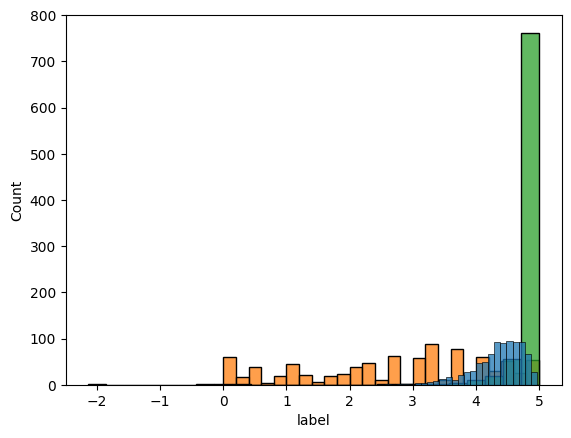

In [51]:
# some visualization of pretrained BERT
import seaborn as ses

ses.histplot(sts_cos_df["label"], bins=25, color="tab:orange")
ses.histplot(sts_cos_df["cls_cos"] * 5, bins=25, color="tab:green")
ses.histplot(sts_cos_df["avg_cos"] * 5, bins=25, color="tab:blue")